In [1]:
import os
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms.functional as tf
from torch.utils.tensorboard import SummaryWriter
import datetime

In [2]:
torch.manual_seed(2)

In [3]:
# Number of Historical Days used as Input!
num_days_history = 84

In [4]:
base_folder = "/scratch/w28/ad0033/FD/" 

In [5]:
curr_dir = "flash_drought_ml_retrain/"
curr_folder = base_folder + curr_dir

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [7]:
# Building mask to remove invalid areas
file_path = base_folder + "flash_drought_ml/data/FD/" + os.listdir(base_folder + "flash_drought_ml/data/FD/")[0]
im = Image.open(file_path)
mask = tf.to_tensor(im)
mask[mask >= 0] = True
mask[mask < 0] = False
mask = mask.bool().to(device)
print(f"Number of valid points:, {torch.sum(mask):,}")

Number of valid points:, 152,661


In [8]:
image_shape = mask.shape

In [9]:
class CustomDataset(Dataset):
    def __init__(self, start_pt, num_pts):
        self.start_pt = start_pt
        self.num_pts = num_pts
        self.factor = 2

        base = base_folder + "flash_drought_ml/data/"
        self.input_folder = base + "input/"
        self.output_folder = base + "output/"
        self.input_files = sorted(os.listdir(self.input_folder))
        self.output_files = sorted(os.listdir(self.output_folder))
        
        months = torch.arange(12)
        months_sin = torch.sin(2 * torch.pi * months / 12).unsqueeze(1).unsqueeze(2)
        months_cos = torch.cos(2 * torch.pi * months / 12).unsqueeze(1).unsqueeze(2)
        self.months_sin = months_sin.repeat(1, image_shape[1], image_shape[2])
        self.months_cos = months_cos.repeat(1, image_shape[1], image_shape[2])
        
        y_axis = torch.arange(image_shape[1]).unsqueeze(0).unsqueeze(2).repeat(1, 1, image_shape[2]) / image_shape[1]
        x_axis = torch.arange(image_shape[2]).unsqueeze(0).unsqueeze(1).repeat(1, image_shape[1], 1) / image_shape[2]
        self.position = torch.cat([y_axis, x_axis], 0)

        end_pt = start_pt + num_pts * self.factor

        assert end_pt <= len(self.output_files), f"{end_pt} > {len(self.output_files)}"

    def __len__(self):
        return self.num_pts

    def __getitem__(self, idx):
        idx = idx * self.factor
        output_file_name = self.output_files[self.start_pt + idx]
        month = int(output_file_name[4:6])
        input = []
        for i in range(num_days_history):
            # assert self.start_pt + idx + 67 - i >= 0
            input.append(torch.load(self.input_folder + self.input_files[self.start_pt + idx + 67 - i]))
        input.append(self.months_sin[month-1].unsqueeze(0))
        input.append(self.months_cos[month-1].unsqueeze(0))
        input.append(self.position)
        input = torch.cat(input, 0)
        output = torch.load(self.output_folder + output_file_name)
        return input, output, output_file_name

In [10]:
dataloader = DataLoader(CustomDataset(22, 913), batch_size=2, shuffle=False)
train_features, train_labels, file_names = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(file_names)

Feature batch shape: torch.Size([2, 508, 676, 407])
Labels batch shape: torch.Size([2, 1, 676, 407])
('20010401.pt', '20010403.pt')


Model

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        convs = []
        bns = []
        dropouts = []
        conv_chs = [6 * num_days_history + 4, 512, 256, 128, 64, 32, 16, 8]
        for i in range(len(conv_chs) - 1):
            convs.append(nn.Conv2d(conv_chs[i], conv_chs[i + 1], kernel_size=(3,3), padding="same"))
            bns.append(nn.BatchNorm2d(conv_chs[i + 1]))
            dropouts.append(nn.Dropout2d(0.1))
        self.convs = nn.ModuleList(convs)
        self.bns = nn.ModuleList(bns)
        self.dropouts = nn.ModuleList(dropouts)
        self.act = nn.ReLU()
        self.final_conv = nn.Conv2d(conv_chs[-1], 1, kernel_size=(3,3), padding="same")
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        for conv, bn, dropout in zip(self.convs, self.bns, self.dropouts):
            x = self.act(bn(conv(x)))
            x = dropout(x)
        x = self.sigmoid(self.final_conv(x))
        return x

In [12]:
BATCH_SIZE = 2
train_dataloader = DataLoader(CustomDataset(22, 2694), batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_dataloader = DataLoader(CustomDataset(5410, 364), batch_size=BATCH_SIZE, shuffle=False, num_workers=8)
test_dataloader = DataLoader(CustomDataset(6141, 912), batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

In [13]:
train_steps = len(train_dataloader.dataset) // BATCH_SIZE
batch_mask = mask.repeat(BATCH_SIZE, 1, 1, 1)

In [14]:
eps = 1e-8
mask_sum = torch.sum(mask)
class WeightedBCELoss(nn.Module):
    def __init__(self, alpha=0.95):
        super().__init__()
        self.alpha = alpha
 
    def forward(self, output, target):
        output = torch.clamp(output, eps, 1. - eps)
        pt = (target * output) + ((1 - target) * (1 - output))
        BCE_loss = -torch.log(pt)
        BCE_loss = BCE_loss * mask
        alpha_t = (target * self.alpha) + ((1 - target) * (1 - self.alpha))
        final_loss = alpha_t * BCE_loss
        return torch.sum(final_loss) / mask_sum

eps = 1e-8
mask_sum = torch.sum(mask)
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.99, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
 
    def forward(self, output, target):
        output = torch.clamp(output, eps, 1. - eps)
        pt = (target * output) + ((1 - target) * (1 - output))
        BCE_loss = -torch.log(pt)
        pt = pt * mask
        BCE_loss = BCE_loss * mask
        alpha_t = (target * self.alpha) + ((1 - target) * (1 - self.alpha))
        F_loss = alpha_t * ((1 - pt) ** self.gamma) * BCE_loss
        return torch.sum(F_loss) / mask_sum



model = Net().to(device)
loss_fn = WeightedBCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print(model)

Net(
  (convs): ModuleList(
    (0): Conv2d(508, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (bns): ModuleList(
    (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_ru

In [15]:
def get_metrics(dataloader, threshold=0.5):
    model.eval()

    correct_num = 0
    correct_denom = 0
    recall_num = 0
    recall_denom = 0
    precision_num = 0
    precision_denom = 0
    with torch.no_grad():
        for inputs, labels, _ in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            y_pred = model(inputs)
            pred = y_pred > threshold

            pred = pred[batch_mask]
            labels = labels[batch_mask]
            
            correct_num += (pred == labels).float().sum().item()
            correct_denom += labels.numel()
            recall_num += (pred[labels > 0] == labels[labels > 0]).float().sum().item()
            recall_denom += labels[labels > 0].numel()
            precision_num += (pred[pred > 0] == labels[pred > 0]).float().sum().item()
            precision_denom += labels[pred > 0].numel()
        
        correct = 0
        if correct_denom > 0:
            correct = correct_num / correct_denom
        recall = 0
        if recall_denom > 0:
            recall = recall_num / recall_denom
        precision = 0
        if precision_denom > 0:
            precision = precision_num / precision_denom
        
        torch.cuda.empty_cache()
        
        return correct, recall, precision

In [21]:
log_dir = base_folder + "logs/retrain" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter(log_dir=log_dir)
print(log_dir)

2024-08-11 02:38:18.012338: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-11 02:38:18.519209: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


/scratch/w28/ad0033/FD/logs/retrain20240811-023817


In [ ]:
best_model_value = 0

n_epochs = 200
nan_found = False
for epoch in range(n_epochs):
    model.train()

    total_train_loss = 0
    train_correct = 0
    train_recall = 0
    train_precision = 0
    for inputs, labels, _ in tqdm(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)

        if torch.isnan(loss):
            print(f"NaN detected in loss!")
            torch.save(model.state_dict(), curr_folder + "model_nan.pt")
            nan_found = True
            break
        
        optimizer.zero_grad()
        loss.backward()

        # Check for NaNs in gradients
        for name, param in model.named_parameters():
            if param.grad is not None:
                if torch.isnan(param.grad).any():
                    print(f"NaN detected in gradients of {name}")
                    nan_found = True
        if nan_found == True:
            break
    
        optimizer.step()

        # Check for NaNs in model weights
        for name, param in model.named_parameters():
            if torch.isnan(param).any():
                print(f"NaN detected in weights of {name}")
                nan_found = True
        if nan_found == True:
            break

        total_train_loss += loss

        # pred = torch.argmax(y_pred, dim=1)
        pred = y_pred > 0.5

        pred = pred[batch_mask]
        labels = labels[batch_mask]
        
        train_correct += ((pred == labels).float().sum().item() / labels.numel())
        if labels[labels > 0].numel() > 0:
            train_recall += ((pred[labels > 0] == labels[labels > 0]).float().sum().item() / labels[labels > 0].numel())
        if labels[pred > 0].numel() > 0:
            train_precision += ((pred[pred > 0] == labels[pred > 0]).float().sum().item() / labels[pred > 0].numel())
    
    if nan_found == True:
        break

    avg_train_loss = total_train_loss / train_steps
    train_correct = train_correct / train_steps
    train_recall = train_recall / train_steps
    train_precision = train_precision / train_steps
    
    print("Epoch: %d, Loss: %.4f" % (epoch+1, avg_train_loss))
    print("[Training Metrics]   Accuracy: %.4f, Recall: %.4f, Precision: %.4f" % (100*train_correct, 100*train_recall, 100*train_precision))
    
    with torch.no_grad():
        val_correct, val_recall, val_precision = get_metrics(val_dataloader)

    print("[Validation Metrics] Accuracy: %.4f, Recall: %.4f, Precision: %.4f" % (100*val_correct, 100*val_recall, 100*val_precision))
    
    writer.add_scalar('Loss/train', avg_train_loss.item(), epoch)
    writer.add_scalar('Accuracy/train', 100*train_correct, epoch)
    writer.add_scalar('Recall/train', 100*train_recall, epoch)
    writer.add_scalar('Precision/train', 100*train_precision, epoch)
    writer.add_scalar('Accuracy/validation', 100*val_correct, epoch)
    writer.add_scalar('Recall/validation', 100*val_recall, epoch)
    writer.add_scalar('Precision/validation', 100*val_precision, epoch)

    model_value = 0
    if (val_recall + val_precision) > 1e-4:
        model_value = 2 * (val_recall * val_precision) / (val_recall + val_precision) # F1 Score
    print("Model Value:", model_value)
    if model_value > best_model_value:
        print("Saving Model!")
        torch.save(model.state_dict(), curr_folder + "model.pt")
        best_model_value = model_value

100%|██████████| 1347/1347 [21:03<00:00,  1.07it/s]


Epoch: 1, Loss: 0.0651
[Training Metrics]   Accuracy: 84.8755, Recall: 54.4794, Precision: 7.4213
[Validation Metrics] Accuracy: 78.5508, Recall: 83.0984, Precision: 7.0587
Model Value: 0.13012175797639108
Saving Model!


100%|██████████| 1347/1347 [20:50<00:00,  1.08it/s]


Epoch: 2, Loss: 0.0584
[Training Metrics]   Accuracy: 86.4994, Recall: 61.1278, Precision: 9.0660
[Validation Metrics] Accuracy: 87.6945, Recall: 76.5679, Precision: 11.0880
Model Value: 0.19370928219936348
Saving Model!


100%|██████████| 1347/1347 [21:06<00:00,  1.06it/s]


Epoch: 3, Loss: 0.0555
[Training Metrics]   Accuracy: 86.8668, Recall: 63.2876, Precision: 9.8257
[Validation Metrics] Accuracy: 87.1378, Recall: 72.2109, Precision: 10.1610
Model Value: 0.17815179659388428


100%|██████████| 1347/1347 [20:51<00:00,  1.08it/s]


Epoch: 4, Loss: 0.0532
[Training Metrics]   Accuracy: 87.8192, Recall: 63.9945, Precision: 10.5063
[Validation Metrics] Accuracy: 63.5012, Recall: 89.5888, Precision: 4.5482
Model Value: 0.08656881683107605


100%|██████████| 1347/1347 [20:55<00:00,  1.07it/s]


Epoch: 5, Loss: 0.0511
[Training Metrics]   Accuracy: 88.3348, Recall: 64.7520, Precision: 11.2014
[Validation Metrics] Accuracy: 90.5521, Recall: 69.8356, Precision: 13.1999
Model Value: 0.2220310007057941
Saving Model!


100%|██████████| 1347/1347 [21:16<00:00,  1.05it/s]


Epoch: 6, Loss: 0.0500
[Training Metrics]   Accuracy: 88.2363, Recall: 65.7727, Precision: 11.2654
[Validation Metrics] Accuracy: 83.0567, Recall: 83.3857, Precision: 8.8293
Model Value: 0.1596790008377166


100%|██████████| 1347/1347 [20:54<00:00,  1.07it/s]


Epoch: 7, Loss: 0.0479
[Training Metrics]   Accuracy: 89.1867, Recall: 64.5407, Precision: 11.8048
[Validation Metrics] Accuracy: 91.6609, Recall: 65.2246, Precision: 14.1056
Model Value: 0.23194954434841872
Saving Model!


100%|██████████| 1347/1347 [20:59<00:00,  1.07it/s]


Epoch: 8, Loss: 0.0462
[Training Metrics]   Accuracy: 89.4183, Recall: 65.6636, Precision: 12.1303
[Validation Metrics] Accuracy: 91.9517, Recall: 68.6286, Precision: 15.1114
Model Value: 0.24768936756671922
Saving Model!


100%|██████████| 1347/1347 [21:07<00:00,  1.06it/s]


Epoch: 9, Loss: 0.0458
[Training Metrics]   Accuracy: 89.6059, Recall: 66.3542, Precision: 12.1343
[Validation Metrics] Accuracy: 85.1134, Recall: 82.3456, Precision: 9.8523
Model Value: 0.17598970739570755


100%|██████████| 1347/1347 [20:49<00:00,  1.08it/s]


Epoch: 10, Loss: 0.0439
[Training Metrics]   Accuracy: 89.8952, Recall: 66.9102, Precision: 12.7080
[Validation Metrics] Accuracy: 95.3388, Recall: 58.8434, Precision: 22.7079
Model Value: 0.3276979517125992
Saving Model!


100%|██████████| 1347/1347 [20:45<00:00,  1.08it/s]


Epoch: 11, Loss: 0.0438
[Training Metrics]   Accuracy: 89.9227, Recall: 67.0975, Precision: 12.7179
[Validation Metrics] Accuracy: 92.5421, Recall: 67.8460, Precision: 16.0771
Model Value: 0.2599446778799021


100%|██████████| 1347/1347 [20:48<00:00,  1.08it/s]


Epoch: 12, Loss: 0.0428
[Training Metrics]   Accuracy: 90.3830, Recall: 67.2249, Precision: 13.2550
[Validation Metrics] Accuracy: 94.0276, Recall: 66.0064, Precision: 19.3355
Model Value: 0.2990948181188437


100%|██████████| 1347/1347 [20:51<00:00,  1.08it/s]


Epoch: 13, Loss: 0.0420
[Training Metrics]   Accuracy: 90.3431, Recall: 68.2219, Precision: 13.1438
[Validation Metrics] Accuracy: 94.0029, Recall: 61.0745, Precision: 18.3521
Model Value: 0.2822341970099311


100%|██████████| 1347/1347 [20:54<00:00,  1.07it/s]


Epoch: 14, Loss: 0.0416
[Training Metrics]   Accuracy: 90.3664, Recall: 68.7455, Precision: 13.3482
[Validation Metrics] Accuracy: 85.0319, Recall: 86.8114, Precision: 10.2257
Model Value: 0.1829628894719419


100%|██████████| 1347/1347 [20:45<00:00,  1.08it/s]


Epoch: 15, Loss: 0.0408
[Training Metrics]   Accuracy: 90.6176, Recall: 68.9005, Precision: 13.4012
[Validation Metrics] Accuracy: 92.8282, Recall: 70.6598, Precision: 17.1168
Model Value: 0.27557872579440174


100%|██████████| 1347/1347 [20:48<00:00,  1.08it/s]


Epoch: 16, Loss: 0.0403
[Training Metrics]   Accuracy: 90.7393, Recall: 69.5844, Precision: 13.5998
[Validation Metrics] Accuracy: 86.2259, Recall: 83.1211, Precision: 10.6603
Model Value: 0.188970684456717


100%|██████████| 1347/1347 [20:42<00:00,  1.08it/s]


Epoch: 17, Loss: 0.0395
[Training Metrics]   Accuracy: 90.7034, Recall: 70.2849, Precision: 13.7068
[Validation Metrics] Accuracy: 92.3274, Recall: 70.6922, Precision: 16.1098
Model Value: 0.26239923491542616


100%|██████████| 1347/1347 [20:47<00:00,  1.08it/s]


Epoch: 18, Loss: 0.0389
[Training Metrics]   Accuracy: 90.8568, Recall: 70.4980, Precision: 14.0214
[Validation Metrics] Accuracy: 90.8820, Recall: 75.7661, Precision: 14.4637
Model Value: 0.24290425630312307


100%|██████████| 1347/1347 [21:12<00:00,  1.06it/s]


Epoch: 19, Loss: 0.0384
[Training Metrics]   Accuracy: 91.1176, Recall: 71.2061, Precision: 14.4249
[Validation Metrics] Accuracy: 87.1615, Recall: 80.1755, Precision: 11.0531
Model Value: 0.19427805123373668


100%|██████████| 1347/1347 [20:41<00:00,  1.09it/s]


Epoch: 20, Loss: 0.0381
[Training Metrics]   Accuracy: 91.2064, Recall: 70.9545, Precision: 14.3391
[Validation Metrics] Accuracy: 88.9839, Recall: 76.2858, Precision: 12.2412
Model Value: 0.21096990613187938


100%|██████████| 1347/1347 [20:49<00:00,  1.08it/s]


Epoch: 21, Loss: 0.0372
[Training Metrics]   Accuracy: 91.3489, Recall: 71.3898, Precision: 14.5334
[Validation Metrics] Accuracy: 89.1524, Recall: 79.8211, Precision: 12.8426
Model Value: 0.22125377448936762


100%|██████████| 1347/1347 [20:46<00:00,  1.08it/s]


Epoch: 22, Loss: 0.0370
[Training Metrics]   Accuracy: 91.3476, Recall: 72.0548, Precision: 14.6950
[Validation Metrics] Accuracy: 87.1966, Recall: 82.8657, Precision: 11.3681
Model Value: 0.1999334502770225


100%|██████████| 1347/1347 [20:41<00:00,  1.09it/s]


Epoch: 23, Loss: 0.0371
[Training Metrics]   Accuracy: 91.4046, Recall: 71.8824, Precision: 14.7883
[Validation Metrics] Accuracy: 90.4329, Recall: 69.8768, Precision: 13.0534
Model Value: 0.21997461093279294


100%|██████████| 1347/1347 [20:47<00:00,  1.08it/s]


Epoch: 24, Loss: 0.0369
[Training Metrics]   Accuracy: 91.4179, Recall: 72.4195, Precision: 14.8880
[Validation Metrics] Accuracy: 91.2615, Recall: 74.5289, Precision: 14.8552
Model Value: 0.24772642946830606


100%|██████████| 1347/1347 [20:45<00:00,  1.08it/s]


Epoch: 25, Loss: 0.0362
[Training Metrics]   Accuracy: 91.6522, Recall: 72.6459, Precision: 15.1800
[Validation Metrics] Accuracy: 88.2751, Recall: 81.3288, Precision: 12.1387
Model Value: 0.21124496902909737


100%|██████████| 1347/1347 [20:46<00:00,  1.08it/s]


Epoch: 26, Loss: 0.0354
[Training Metrics]   Accuracy: 91.8991, Recall: 72.3325, Precision: 15.5069
[Validation Metrics] Accuracy: 89.4408, Recall: 77.2208, Precision: 12.8403
Model Value: 0.22019217479134548


100%|██████████| 1347/1347 [20:50<00:00,  1.08it/s]


Epoch: 27, Loss: 0.0349
[Training Metrics]   Accuracy: 92.0229, Recall: 72.5612, Precision: 15.6211
[Validation Metrics] Accuracy: 94.1512, Recall: 65.9814, Precision: 19.7004
Model Value: 0.30341614447559095


100%|██████████| 1347/1347 [20:45<00:00,  1.08it/s]


Epoch: 28, Loss: 0.0352
[Training Metrics]   Accuracy: 91.9080, Recall: 73.1941, Precision: 15.7513
[Validation Metrics] Accuracy: 94.3382, Recall: 68.6937, Precision: 20.7747
Model Value: 0.31901621119926854


100%|██████████| 1347/1347 [20:46<00:00,  1.08it/s]


Epoch: 29, Loss: 0.0348
[Training Metrics]   Accuracy: 91.8526, Recall: 73.6015, Precision: 15.7013
[Validation Metrics] Accuracy: 90.8609, Recall: 79.2926, Precision: 14.9052
Model Value: 0.2509345148568798


100%|██████████| 1347/1347 [20:38<00:00,  1.09it/s]


Epoch: 30, Loss: 0.0344
[Training Metrics]   Accuracy: 92.0181, Recall: 74.6580, Precision: 15.8120
[Validation Metrics] Accuracy: 93.9675, Recall: 70.2081, Precision: 19.8950
Model Value: 0.31004313244104587


100%|██████████| 1347/1347 [20:47<00:00,  1.08it/s]


Epoch: 31, Loss: 0.0343
[Training Metrics]   Accuracy: 92.0595, Recall: 73.5331, Precision: 15.9412
[Validation Metrics] Accuracy: 84.1048, Recall: 84.3656, Precision: 9.4571
Model Value: 0.17007762773228138


100%|██████████| 1347/1347 [20:41<00:00,  1.08it/s]


Epoch: 32, Loss: 0.0340
[Training Metrics]   Accuracy: 92.2750, Recall: 73.4944, Precision: 16.0145
[Validation Metrics] Accuracy: 91.4195, Recall: 76.6076, Precision: 15.3931
Model Value: 0.2563526774309365


100%|██████████| 1347/1347 [20:57<00:00,  1.07it/s]


Epoch: 33, Loss: 0.0341
[Training Metrics]   Accuracy: 92.0605, Recall: 74.3577, Precision: 15.8926
[Validation Metrics] Accuracy: 91.6910, Recall: 79.5860, Precision: 16.2563
Model Value: 0.26997922300259153


100%|██████████| 1347/1347 [20:36<00:00,  1.09it/s]


Epoch: 34, Loss: 0.0336
[Training Metrics]   Accuracy: 92.0977, Recall: 74.3759, Precision: 16.0178
[Validation Metrics] Accuracy: 93.3273, Recall: 73.3961, Precision: 18.7029
Model Value: 0.29809627508378295


100%|██████████| 1347/1347 [20:46<00:00,  1.08it/s]


Epoch: 35, Loss: 0.0339
[Training Metrics]   Accuracy: 92.0759, Recall: 73.9975, Precision: 16.0033
[Validation Metrics] Accuracy: 94.7221, Recall: 65.9486, Precision: 21.6023
Model Value: 0.3254432875116812


100%|██████████| 1347/1347 [20:50<00:00,  1.08it/s]


Epoch: 36, Loss: 0.0328
[Training Metrics]   Accuracy: 92.4075, Recall: 74.6841, Precision: 16.4275
[Validation Metrics] Accuracy: 92.8808, Recall: 76.7961, Precision: 18.1828
Model Value: 0.29403738519225453


100%|██████████| 1347/1347 [20:51<00:00,  1.08it/s]


Epoch: 37, Loss: 0.0328
[Training Metrics]   Accuracy: 92.3919, Recall: 74.4449, Precision: 16.3936
[Validation Metrics] Accuracy: 93.5993, Recall: 68.7683, Precision: 18.6320
Model Value: 0.2932007379598637


100%|██████████| 1347/1347 [20:51<00:00,  1.08it/s]


Epoch: 38, Loss: 0.0326
[Training Metrics]   Accuracy: 92.3946, Recall: 74.5114, Precision: 16.4957
[Validation Metrics] Accuracy: 87.9707, Recall: 82.3918, Precision: 11.9775
Model Value: 0.20914642947566683


100%|██████████| 1347/1347 [20:46<00:00,  1.08it/s]


Epoch: 39, Loss: 0.0324
[Training Metrics]   Accuracy: 92.5047, Recall: 75.3808, Precision: 16.7822
[Validation Metrics] Accuracy: 93.0297, Recall: 73.1151, Precision: 17.9518
Model Value: 0.28826070850006025


100%|██████████| 1347/1347 [20:46<00:00,  1.08it/s]


Epoch: 40, Loss: 0.0318
[Training Metrics]   Accuracy: 92.6624, Recall: 75.5572, Precision: 16.8528
[Validation Metrics] Accuracy: 94.0740, Recall: 69.5069, Precision: 20.0901
Model Value: 0.3117067593581547


100%|██████████| 1347/1347 [20:46<00:00,  1.08it/s]


Epoch: 41, Loss: 0.0323
[Training Metrics]   Accuracy: 92.5793, Recall: 74.8704, Precision: 16.6533
[Validation Metrics] Accuracy: 92.7091, Recall: 75.2610, Precision: 17.5768
Model Value: 0.28497991174049125


100%|██████████| 1347/1347 [21:02<00:00,  1.07it/s]


Epoch: 42, Loss: 0.0312
[Training Metrics]   Accuracy: 92.6827, Recall: 75.5032, Precision: 17.1529
[Validation Metrics] Accuracy: 93.2400, Recall: 72.1114, Precision: 18.2846
Model Value: 0.2917229488946057


100%|██████████| 1347/1347 [20:42<00:00,  1.08it/s]


Epoch: 43, Loss: 0.0315
[Training Metrics]   Accuracy: 92.6625, Recall: 75.8420, Precision: 17.1868
[Validation Metrics] Accuracy: 92.2445, Recall: 72.9039, Precision: 16.2902
Model Value: 0.26629993064112867


100%|██████████| 1347/1347 [20:45<00:00,  1.08it/s]


Epoch: 44, Loss: 0.0311
[Training Metrics]   Accuracy: 92.7033, Recall: 75.4341, Precision: 17.0822
[Validation Metrics] Accuracy: 92.2099, Recall: 77.9066, Precision: 16.9608
Model Value: 0.27856975368113385


100%|██████████| 1347/1347 [20:45<00:00,  1.08it/s]


Epoch: 45, Loss: 0.0311
[Training Metrics]   Accuracy: 92.8608, Recall: 75.7563, Precision: 17.3589
[Validation Metrics] Accuracy: 95.3988, Recall: 61.4562, Precision: 23.5239
Model Value: 0.3402418532448713
Saving Model!


100%|██████████| 1347/1347 [20:40<00:00,  1.09it/s]


Epoch: 46, Loss: 0.0307
[Training Metrics]   Accuracy: 92.8600, Recall: 75.8243, Precision: 17.4327
[Validation Metrics] Accuracy: 95.3990, Recall: 55.1139, Precision: 22.1737
Model Value: 0.3162414671489413


100%|██████████| 1347/1347 [20:49<00:00,  1.08it/s]


Epoch: 47, Loss: 0.0308
[Training Metrics]   Accuracy: 92.7402, Recall: 76.4002, Precision: 17.2689
[Validation Metrics] Accuracy: 93.9317, Recall: 70.2138, Precision: 19.7919
Model Value: 0.30879540815040185


100%|██████████| 1347/1347 [20:48<00:00,  1.08it/s]


Epoch: 48, Loss: 0.0309
[Training Metrics]   Accuracy: 92.8289, Recall: 75.9947, Precision: 17.4223
[Validation Metrics] Accuracy: 94.2290, Recall: 68.2537, Precision: 20.3475
Model Value: 0.3134924950356517


100%|██████████| 1347/1347 [20:52<00:00,  1.08it/s]


Epoch: 49, Loss: 0.0304
[Training Metrics]   Accuracy: 92.9266, Recall: 76.8220, Precision: 17.4849
[Validation Metrics] Accuracy: 92.4562, Recall: 75.4279, Precision: 17.0800
Model Value: 0.27852881485683445


100%|██████████| 1347/1347 [20:56<00:00,  1.07it/s]


Epoch: 50, Loss: 0.0304
[Training Metrics]   Accuracy: 92.8588, Recall: 76.6413, Precision: 17.6633
[Validation Metrics] Accuracy: 92.6649, Recall: 77.8542, Precision: 17.8705
Model Value: 0.2906870388417096


100%|██████████| 1347/1347 [20:53<00:00,  1.07it/s]


Epoch: 51, Loss: 0.0299
[Training Metrics]   Accuracy: 92.9297, Recall: 77.4319, Precision: 17.7826
[Validation Metrics] Accuracy: 89.8971, Recall: 83.5471, Precision: 14.1506
Model Value: 0.2420209483942796


100%|██████████| 1347/1347 [20:51<00:00,  1.08it/s]


Epoch: 52, Loss: 0.0299
[Training Metrics]   Accuracy: 92.9671, Recall: 76.4860, Precision: 17.6212
[Validation Metrics] Accuracy: 94.7956, Recall: 58.6116, Precision: 20.4361
Model Value: 0.3030552929436014


100%|██████████| 1347/1347 [20:56<00:00,  1.07it/s]


Epoch: 53, Loss: 0.0301
[Training Metrics]   Accuracy: 92.8405, Recall: 77.5362, Precision: 17.7178
[Validation Metrics] Accuracy: 94.7520, Recall: 65.1437, Precision: 21.5616
Model Value: 0.32399439492158566


100%|██████████| 1347/1347 [20:42<00:00,  1.08it/s]


Epoch: 54, Loss: 0.0292
[Training Metrics]   Accuracy: 93.0879, Recall: 76.5758, Precision: 17.8246
[Validation Metrics] Accuracy: 94.6165, Recall: 69.0694, Precision: 21.7888
Model Value: 0.3312716807714163


100%|██████████| 1347/1347 [20:49<00:00,  1.08it/s]


Epoch: 55, Loss: 0.0290
[Training Metrics]   Accuracy: 93.1617, Recall: 76.7844, Precision: 18.1685
[Validation Metrics] Accuracy: 94.4763, Recall: 68.9045, Precision: 21.2713
Model Value: 0.32507388122713204


100%|██████████| 1347/1347 [20:54<00:00,  1.07it/s]


Epoch: 56, Loss: 0.0296
[Training Metrics]   Accuracy: 93.1213, Recall: 76.4919, Precision: 17.8735
[Validation Metrics] Accuracy: 94.0251, Recall: 64.3453, Precision: 19.0267
Model Value: 0.2936901558261979


100%|██████████| 1347/1347 [20:43<00:00,  1.08it/s]


Epoch: 57, Loss: 0.0291
[Training Metrics]   Accuracy: 93.0529, Recall: 77.5447, Precision: 17.9205
[Validation Metrics] Accuracy: 93.4076, Recall: 70.7250, Precision: 18.4696
Model Value: 0.29290191872796156


100%|██████████| 1347/1347 [20:41<00:00,  1.08it/s]


Epoch: 58, Loss: 0.0290
[Training Metrics]   Accuracy: 93.1690, Recall: 77.5719, Precision: 18.3423
[Validation Metrics] Accuracy: 91.9361, Recall: 70.2532, Precision: 15.3322
Model Value: 0.25170965919034494


100%|██████████| 1347/1347 [20:47<00:00,  1.08it/s]


Epoch: 59, Loss: 0.0288
[Training Metrics]   Accuracy: 93.1226, Recall: 77.6768, Precision: 18.1520
[Validation Metrics] Accuracy: 95.3775, Recall: 64.7942, Precision: 24.0844
Model Value: 0.3511594728594134
Saving Model!


100%|██████████| 1347/1347 [20:45<00:00,  1.08it/s]


Epoch: 60, Loss: 0.0288
[Training Metrics]   Accuracy: 93.1668, Recall: 78.3220, Precision: 18.3510
[Validation Metrics] Accuracy: 88.1024, Recall: 86.4136, Precision: 12.5399
Model Value: 0.21901489426496495


100%|██████████| 1347/1347 [20:40<00:00,  1.09it/s]


Epoch: 61, Loss: 0.0286
[Training Metrics]   Accuracy: 93.2761, Recall: 77.3986, Precision: 18.4229
[Validation Metrics] Accuracy: 95.6453, Recall: 66.4160, Precision: 25.7029
Model Value: 0.3706260676691573
Saving Model!


100%|██████████| 1347/1347 [21:10<00:00,  1.06it/s]


Epoch: 62, Loss: 0.0283
[Training Metrics]   Accuracy: 93.2969, Recall: 78.2935, Precision: 18.6436
[Validation Metrics] Accuracy: 95.5270, Recall: 64.4425, Precision: 24.7303
Model Value: 0.3574373259052925


100%|██████████| 1347/1347 [20:49<00:00,  1.08it/s]


Epoch: 63, Loss: 0.0281
[Training Metrics]   Accuracy: 93.3808, Recall: 77.7597, Precision: 18.5821
[Validation Metrics] Accuracy: 95.3678, Recall: 68.3081, Precision: 24.6995
Model Value: 0.36280388106292305


100%|██████████| 1347/1347 [20:55<00:00,  1.07it/s]


Epoch: 64, Loss: 0.0281
[Training Metrics]   Accuracy: 93.3673, Recall: 77.4569, Precision: 18.4915
[Validation Metrics] Accuracy: 89.9976, Recall: 79.5426, Precision: 13.7809
Model Value: 0.23491758826770662


100%|██████████| 1347/1347 [21:02<00:00,  1.07it/s]


Epoch: 65, Loss: 0.0276
[Training Metrics]   Accuracy: 93.3908, Recall: 78.1859, Precision: 18.8078
[Validation Metrics] Accuracy: 93.4330, Recall: 72.6006, Precision: 18.8394
Model Value: 0.29915884465302295


100%|██████████| 1347/1347 [20:57<00:00,  1.07it/s]


Epoch: 66, Loss: 0.0279
[Training Metrics]   Accuracy: 93.4101, Recall: 77.5974, Precision: 18.5823
[Validation Metrics] Accuracy: 94.8900, Recall: 68.0552, Precision: 22.6245
Model Value: 0.33959365327147506


100%|██████████| 1347/1347 [21:04<00:00,  1.06it/s]


Epoch: 67, Loss: 0.0276
[Training Metrics]   Accuracy: 93.4817, Recall: 78.9152, Precision: 19.1378
[Validation Metrics] Accuracy: 89.7157, Recall: 84.1335, Precision: 13.9993
Model Value: 0.24004477676246666


100%|██████████| 1347/1347 [20:45<00:00,  1.08it/s]


Epoch: 68, Loss: 0.0279
[Training Metrics]   Accuracy: 93.3282, Recall: 78.2049, Precision: 18.7431
[Validation Metrics] Accuracy: 93.1367, Recall: 71.5420, Precision: 17.9485
Model Value: 0.28697335922559525


100%|██████████| 1347/1347 [20:51<00:00,  1.08it/s]


Epoch: 69, Loss: 0.0277
[Training Metrics]   Accuracy: 93.3701, Recall: 78.9932, Precision: 18.8213
[Validation Metrics] Accuracy: 86.6021, Recall: 87.5607, Precision: 11.3846
Model Value: 0.20149311920381846


100%|██████████| 1347/1347 [20:51<00:00,  1.08it/s]


Epoch: 70, Loss: 0.0276
[Training Metrics]   Accuracy: 93.3850, Recall: 79.1698, Precision: 19.0674
[Validation Metrics] Accuracy: 93.0613, Recall: 68.8604, Precision: 17.3393
Model Value: 0.2770289286981964


100%|██████████| 1347/1347 [20:56<00:00,  1.07it/s]


Epoch: 71, Loss: 0.0270
[Training Metrics]   Accuracy: 93.5766, Recall: 79.5221, Precision: 19.4704
[Validation Metrics] Accuracy: 93.2593, Recall: 77.0031, Precision: 19.0995
Model Value: 0.3060727544887993


100%|██████████| 1347/1347 [20:53<00:00,  1.07it/s]


Epoch: 72, Loss: 0.0271
[Training Metrics]   Accuracy: 93.5733, Recall: 79.0988, Precision: 19.3264
[Validation Metrics] Accuracy: 92.6890, Recall: 79.4987, Precision: 18.1629
Model Value: 0.29569942151237527


100%|██████████| 1347/1347 [20:49<00:00,  1.08it/s]


Epoch: 73, Loss: 0.0271
[Training Metrics]   Accuracy: 93.5124, Recall: 78.8831, Precision: 19.2046
[Validation Metrics] Accuracy: 95.0462, Recall: 68.1719, Precision: 23.2712
Model Value: 0.34697907449536586


100%|██████████| 1347/1347 [20:55<00:00,  1.07it/s]


Epoch: 74, Loss: 0.0268
[Training Metrics]   Accuracy: 93.6395, Recall: 79.0379, Precision: 19.2406
[Validation Metrics] Accuracy: 92.5704, Recall: 73.3178, Precision: 16.9921
Model Value: 0.2759001586570521


100%|██████████| 1347/1347 [20:55<00:00,  1.07it/s]


Epoch: 75, Loss: 0.0269
[Training Metrics]   Accuracy: 93.6522, Recall: 78.6645, Precision: 19.2170
[Validation Metrics] Accuracy: 94.1896, Recall: 67.4122, Precision: 20.0752
Model Value: 0.3093736384106326


100%|██████████| 1347/1347 [21:01<00:00,  1.07it/s]


Epoch: 76, Loss: 0.0270
[Training Metrics]   Accuracy: 93.5556, Recall: 79.0644, Precision: 19.0070
[Validation Metrics] Accuracy: 93.4934, Recall: 74.8265, Precision: 19.3507
Model Value: 0.30749385085846653


100%|██████████| 1347/1347 [20:57<00:00,  1.07it/s]


Epoch: 77, Loss: 0.0267
[Training Metrics]   Accuracy: 93.6240, Recall: 79.3218, Precision: 19.5206
[Validation Metrics] Accuracy: 93.5567, Recall: 68.9691, Precision: 18.5553
Model Value: 0.2924306204267266


100%|██████████| 1347/1347 [21:01<00:00,  1.07it/s]


Epoch: 78, Loss: 0.0264
[Training Metrics]   Accuracy: 93.6891, Recall: 80.0453, Precision: 19.7978
[Validation Metrics] Accuracy: 92.3910, Recall: 73.2211, Precision: 16.6192
Model Value: 0.27089778156678784


100%|██████████| 1347/1347 [20:59<00:00,  1.07it/s]


Epoch: 79, Loss: 0.0264
[Training Metrics]   Accuracy: 93.7165, Recall: 79.5789, Precision: 19.7268
[Validation Metrics] Accuracy: 92.8913, Recall: 77.7612, Precision: 18.3509
Model Value: 0.29694197859158983


100%|██████████| 1347/1347 [20:50<00:00,  1.08it/s]


Epoch: 80, Loss: 0.0267
[Training Metrics]   Accuracy: 93.6019, Recall: 79.9341, Precision: 19.3812
[Validation Metrics] Accuracy: 94.8522, Recall: 61.0421, Precision: 21.1413
Model Value: 0.31405636839082596


100%|██████████| 1347/1347 [20:49<00:00,  1.08it/s]


Epoch: 81, Loss: 0.0263
[Training Metrics]   Accuracy: 93.7110, Recall: 79.6177, Precision: 19.7320
[Validation Metrics] Accuracy: 94.5344, Recall: 66.2384, Precision: 20.9889
Model Value: 0.31877001312600883


100%|██████████| 1347/1347 [20:48<00:00,  1.08it/s]


Epoch: 82, Loss: 0.0263
[Training Metrics]   Accuracy: 93.7388, Recall: 79.8324, Precision: 19.8760
[Validation Metrics] Accuracy: 88.6195, Recall: 86.1752, Precision: 13.0204
Model Value: 0.22622696280707336


100%|██████████| 1347/1347 [21:01<00:00,  1.07it/s]


Epoch: 83, Loss: 0.0262
[Training Metrics]   Accuracy: 93.6852, Recall: 79.7824, Precision: 19.7463
[Validation Metrics] Accuracy: 95.5608, Recall: 67.1022, Precision: 25.4029
Model Value: 0.3685395179723024


100%|██████████| 1347/1347 [20:53<00:00,  1.07it/s]


Epoch: 84, Loss: 0.0258
[Training Metrics]   Accuracy: 93.8239, Recall: 79.4919, Precision: 19.8224
[Validation Metrics] Accuracy: 91.9000, Recall: 76.7988, Precision: 16.2307
Model Value: 0.2679794367383714


100%|██████████| 1347/1347 [20:58<00:00,  1.07it/s]


Epoch: 85, Loss: 0.0263
[Training Metrics]   Accuracy: 93.6931, Recall: 79.3169, Precision: 19.7194
[Validation Metrics] Accuracy: 92.9017, Recall: 78.1068, Precision: 18.4259
Model Value: 0.2981769086482876


100%|██████████| 1347/1347 [20:54<00:00,  1.07it/s]


Epoch: 86, Loss: 0.0258
[Training Metrics]   Accuracy: 93.7552, Recall: 79.7828, Precision: 19.8433
[Validation Metrics] Accuracy: 94.6445, Recall: 65.5534, Precision: 21.2482
Model Value: 0.32093672146574254


100%|██████████| 1347/1347 [20:50<00:00,  1.08it/s]


Epoch: 87, Loss: 0.0257
[Training Metrics]   Accuracy: 93.8347, Recall: 80.0611, Precision: 19.9836
[Validation Metrics] Accuracy: 95.3645, Recall: 69.6529, Precision: 24.9280
Model Value: 0.36715766301951086


100%|██████████| 1347/1347 [20:57<00:00,  1.07it/s]


Epoch: 88, Loss: 0.0258
[Training Metrics]   Accuracy: 93.7763, Recall: 80.8438, Precision: 19.9167
[Validation Metrics] Accuracy: 94.0527, Recall: 64.6406, Precision: 19.1616
Model Value: 0.29560519757769216


100%|██████████| 1347/1347 [21:05<00:00,  1.06it/s]


Epoch: 89, Loss: 0.0253
[Training Metrics]   Accuracy: 93.9176, Recall: 80.9579, Precision: 20.3127
[Validation Metrics] Accuracy: 95.9491, Recall: 62.9233, Precision: 26.6990
Model Value: 0.37490481963911715
Saving Model!


100%|██████████| 1347/1347 [20:56<00:00,  1.07it/s]


Epoch: 90, Loss: 0.0256
[Training Metrics]   Accuracy: 93.8037, Recall: 80.7753, Precision: 20.0791
[Validation Metrics] Accuracy: 96.2620, Recall: 60.3036, Precision: 28.1489
Model Value: 0.3838176963391478
Saving Model!


100%|██████████| 1347/1347 [20:51<00:00,  1.08it/s]


Epoch: 91, Loss: 0.0255
[Training Metrics]   Accuracy: 93.9815, Recall: 80.3904, Precision: 20.4858
[Validation Metrics] Accuracy: 94.3489, Recall: 72.4851, Precision: 21.4650
Model Value: 0.33121659925020885


100%|██████████| 1347/1347 [20:55<00:00,  1.07it/s]


Epoch: 92, Loss: 0.0253
[Training Metrics]   Accuracy: 93.9079, Recall: 81.1011, Precision: 20.3708
[Validation Metrics] Accuracy: 90.5521, Recall: 83.2476, Precision: 14.9757
Model Value: 0.2538478199571586


100%|██████████| 1347/1347 [20:55<00:00,  1.07it/s]


Epoch: 93, Loss: 0.0251
[Training Metrics]   Accuracy: 93.9563, Recall: 81.0702, Precision: 20.3540
[Validation Metrics] Accuracy: 93.6100, Recall: 71.9341, Precision: 19.1894
Model Value: 0.3029674154941148


100%|██████████| 1347/1347 [20:57<00:00,  1.07it/s]


Epoch: 94, Loss: 0.0253
[Training Metrics]   Accuracy: 93.8729, Recall: 80.6918, Precision: 20.3262
[Validation Metrics] Accuracy: 95.4492, Recall: 70.1204, Precision: 25.4090
Model Value: 0.3730140233259283


100%|██████████| 1347/1347 [20:59<00:00,  1.07it/s]


Epoch: 95, Loss: 0.0249
[Training Metrics]   Accuracy: 93.9837, Recall: 80.2938, Precision: 20.2717
[Validation Metrics] Accuracy: 93.6402, Recall: 75.3540, Precision: 19.8228
Model Value: 0.3138845513842383


100%|██████████| 1347/1347 [21:00<00:00,  1.07it/s]


Epoch: 96, Loss: 0.0250
[Training Metrics]   Accuracy: 94.0503, Recall: 80.8208, Precision: 20.7101
[Validation Metrics] Accuracy: 92.7881, Recall: 70.8503, Precision: 17.0614
Model Value: 0.2750038669060681


 79%|███████▉  | 1065/1347 [16:33<04:22,  1.07it/s]

In [ ]:
print("Best Model Value:", best_model_value)

In [ ]:
epoch

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model.eval()
torch.save(model.state_dict(), curr_folder + "model_least_loss.pt")
torch.save(optimizer.state_dict(), curr_folder + "optimizer.pt")

In [16]:
checkpoint = torch.load(curr_folder + "model.pt")
model.load_state_dict(checkpoint)
model.eval()

Net(
  (convs): ModuleList(
    (0): Conv2d(508, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (bns): ModuleList(
    (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_ru

In [17]:
def f1_score(recall, precision):
    return 2 * (recall * precision) / (recall + precision + 1e-06)

In [20]:
thresholds = torch.arange(0.0, 1.0, 0.05)
f1_scores_list = []

for threshold in tqdm(thresholds):
    val_correct, val_recall, val_precision = get_metrics(val_dataloader, threshold=threshold)
    f1 = f1_score(val_recall, val_precision)
    f1_scores_list.append(f1)

best_index = torch.argmax(torch.tensor(f1_scores_list))
optimal_threshold = thresholds[best_index]
optimal_f1_score = f1_scores_list[best_index]
print(f'Optimal threshold: {optimal_threshold}, Best F1 Score: {optimal_f1_score}')

Optimal threshold: 0.75, Best F1 Score: 0.5127521522499228


In [18]:
test_correct, test_recall, test_precision = get_metrics(test_dataloader)

print("[Test Metrics] Accuracy: %.4f, Recall: %.4f, Precision: %.4f" % (100*test_correct, 100*test_recall, 100*test_precision))

[Test Metrics] Accuracy: 94.5597, Recall: 65.0572, Precision: 29.2722


In [17]:
val_correct, val_recall, val_precision = get_metrics(val_dataloader)

print("[Validation Metrics] Accuracy: %.4f, Recall: %.4f, Precision: %.4f" % (100*val_correct, 100*val_recall, 100*val_precision))

model_value = 0
if (val_recall + val_precision) > 1e-4:
    model_value = 2 * (val_recall * val_precision) / (val_recall + val_precision) # F1 Score
print("Model Value:", model_value)

[Validation Metrics] Accuracy: 96.2766, Recall: 63.6641, Precision: 28.9121
Model Value: 0.39765404295060053


In [22]:
train_correct, train_recall, train_precision = get_metrics(train_dataloader)

print("[Train Metrics] Accuracy: %.4f, Recall: %.4f, Precision: %.4f" % (100*train_correct, 100*train_recall, 100*train_precision))

[Train Metrics] Accuracy: 96.2932, Recall: 82.6073, Precision: 33.7189


In [19]:
best_model_value = model_value

In [20]:
best_model_value

0.39765404295060053

In [21]:
2 * (test_recall * test_precision) / (test_recall + test_precision)

0.40376915147648446

In [45]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [27]:
def extract_scalar_data(log_dir):
    scalar_data = {}
    for event in tf.compat.v1.train.summary_iterator(log_dir):
        for value in event.summary.value:
            if value.tag not in scalar_data:
                scalar_data[value.tag] = {'step': [], 'value': []}
            scalar_data[value.tag]['step'].append(event.step)
            scalar_data[value.tag]['value'].append(value.simple_value)
    return scalar_data

log_dir_analyze = base_folder + "logs/smaller2/20240722-160303/events.out.tfevents.1721628183.gadi-gpu-v100-0097.gadi.nci.org.au.389032.1"
scalar_data = extract_scalar_data(log_dir_analyze)

In [28]:
print(scalar_data.keys())

dict_keys(['Loss/train', 'Accuracy/train', 'Recall/train', 'Precision/train', 'Accuracy/validation', 'Recall/validation', 'Precision/validation'])


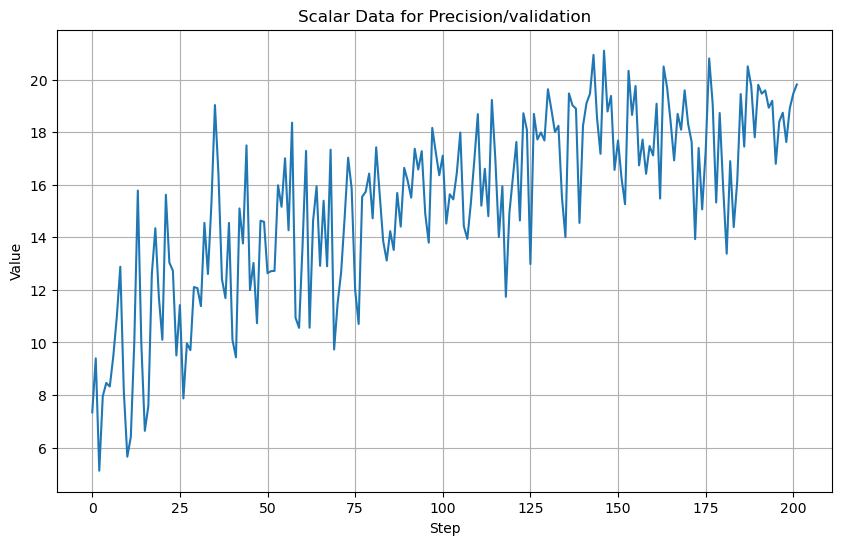

In [34]:
def plot_scalar_data(scalar_data, tag):
    plt.figure(figsize=(10, 6))
    plt.plot(scalar_data[tag]['step'], scalar_data[tag]['value'], linestyle='-')
    plt.xlabel('Step')
    plt.ylabel('Value')
    plt.title(f'Scalar Data for {tag}')
    plt.grid(True)
    plt.show()

tag_to_plot = 'Precision/validation'
plot_scalar_data(scalar_data, tag_to_plot)

In [25]:
from torchmetrics.classification import BinaryAUROC

2024-07-27 12:05:38.015339: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-27 12:05:38.155307: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [37]:
check_dataloader = DataLoader(CustomDataset(4400, 400), batch_size=1, shuffle=False)

In [38]:
auroc = BinaryAUROC().to(device)
with torch.no_grad():
    for inputs, labels, file_name in check_dataloader:
        inputs, labels = inputs.to(device), labels.to(device).squeeze(0)
        y_pred = model(inputs).squeeze(0)
        auroc.update(y_pred[mask], labels[mask])
        torch.cuda.empty_cache()

In [39]:
auroc_value = auroc.compute()
print(f'AUROC: {auroc_value}')

AUROC: 0.8634642362594604


In [40]:
check_dataloader = DataLoader(CustomDataset(4400, 40), batch_size=1, shuffle=False)

In [41]:
all_labels = []
all_pred = []
all_file_name = []

with torch.no_grad():
    for inputs, labels, file_name in check_dataloader:
        inputs, labels = inputs.to(device), labels.to(device).squeeze(0)

        y_pred = model(inputs).squeeze(0)
        pred = y_pred > 0.5

        pred = pred * mask

        all_labels.append(labels.squeeze().cpu())
        all_pred.append(pred.squeeze().cpu().int())
        all_file_name.append(file_name)

        torch.cuda.empty_cache()

In [42]:
i = 25
print(all_file_name[i])

('20130516.pt',)


In [43]:
print(torch.unique(all_labels[i], return_counts=True))
print(torch.unique(all_pred[i], return_counts=True))

(tensor([0., 1.]), tensor([270376,   4756]))
(tensor([0, 1], dtype=torch.int32), tensor([265076,  10056]))


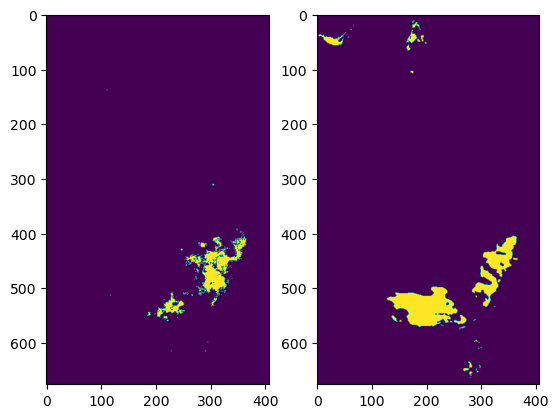

In [46]:
_, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(all_labels[i])
axes[1].imshow(all_pred[i])